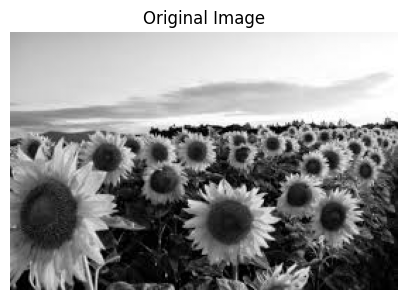

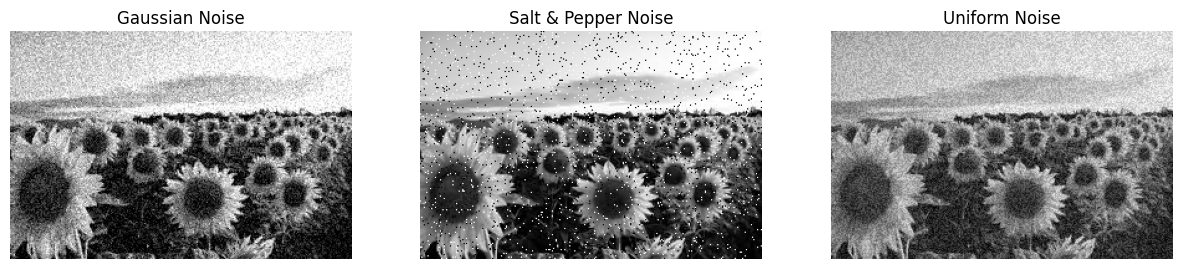

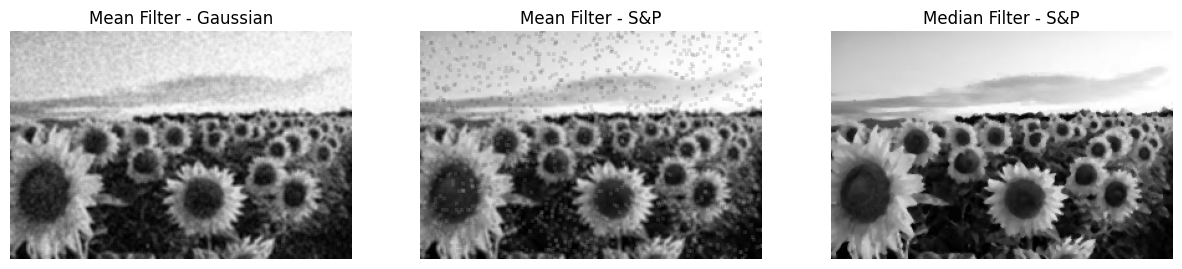

Original Size: 402600 bits
Compressed Size: 398451 bits


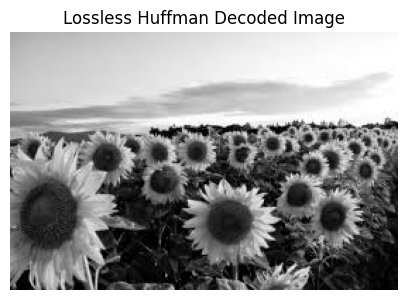

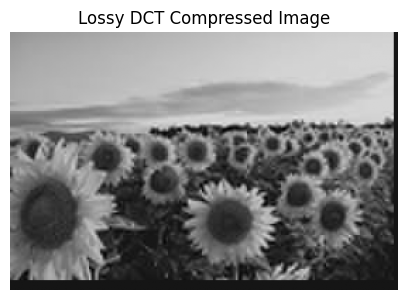

PSNR between original and lossy compressed: 19.51744399797647


In [2]:
# Lab 4: Image Degradation, Restoration, and Compression Techniques

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter, median_filter
from skimage.util import random_noise
from skimage import img_as_ubyte, data
from skimage.metrics import peak_signal_noise_ratio as psnr
from collections import Counter
import heapq

# Load grayscale image
img = cv2.imread(cv2.samples.findFile("img/flower.jpg"), 0)
if img is None:
    img = cv2.cvtColor(data.astronaut(), cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(5,5))
plt.title("Original Image")
plt.imshow(img, cmap='gray')    
plt.axis('off')
plt.show()

### --- 1. ADDING NOISE TO IMAGE ---

# Gaussian Noise
gaussian_img = random_noise(img, mode='gaussian', var=0.01)
gaussian_img = img_as_ubyte(gaussian_img)

# Salt & Pepper Noise
sp_img = random_noise(img, mode='s&p', amount=0.05)
sp_img = img_as_ubyte(sp_img)

# Uniform Noise
uniform_noise = np.random.uniform(low=0, high=255, size=img.shape).astype(np.uint8)
uniform_img = cv2.addWeighted(img, 0.75, uniform_noise, 0.25, 0)

# Plot Noisy Images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(gaussian_img, cmap='gray'); axs[0].set_title("Gaussian Noise")
axs[1].imshow(sp_img, cmap='gray'); axs[1].set_title("Salt & Pepper Noise")
axs[2].imshow(uniform_img, cmap='gray'); axs[2].set_title("Uniform Noise")
for ax in axs: ax.axis('off')
plt.show()

### --- 2. RESTORATION FILTERS ---

# Mean filter
mean_gaussian = uniform_filter(gaussian_img, size=3)
mean_sp = uniform_filter(sp_img, size=3)

# Median filter (for salt and pepper)
median_sp = median_filter(sp_img, size=3)

# Display restored images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(mean_gaussian, cmap='gray'); axs[0].set_title("Mean Filter - Gaussian")
axs[1].imshow(mean_sp, cmap='gray'); axs[1].set_title("Mean Filter - S&P")
axs[2].imshow(median_sp, cmap='gray'); axs[2].set_title("Median Filter - S&P")
for ax in axs: ax.axis('off')
plt.show()

### --- 3. IMAGE COMPRESSION ---

### --- LOSSLESS COMPRESSION USING HUFFMAN CODING WITH DECODING ---


def huffman_encoding(data):
    frequency = Counter(data)
    heap = [[freq, [[val, ""]]] for val, freq in frequency.items()]  # Notice double brackets here
    heapq.heapify(heap)

    if len(heap) == 1:
        only_symbol = heap[0][1][0][0]
        return {only_symbol: '0'}

    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)

        merged = []
        for symbol, code in lo[1]:
            merged.append([symbol, '0' + code])
        for symbol, code in hi[1]:
            merged.append([symbol, '1' + code])

        heapq.heappush(heap, [lo[0] + hi[0], merged])

    return dict(heap[0][1])


def huffman_decoding(encoded_str, encoding_map):
    # Reverse the encoding map to decode
    reverse_map = {v: k for k, v in encoding_map.items()}
    decoded = []
    buffer = ""
    for bit in encoded_str:
        buffer += bit
        if buffer in reverse_map:
            decoded.append(reverse_map[buffer])
            buffer = ""
    return np.array(decoded, dtype=np.uint8)

flat_img = img.flatten().tolist()
encoding_map = huffman_encoding(flat_img)
encoded_data = ''.join(encoding_map[val] for val in flat_img)

print("Original Size:", len(flat_img) * 8, "bits")
print("Compressed Size:", len(encoded_data), "bits")

# Decode to reconstruct image
decoded_flat = huffman_decoding(encoded_data, encoding_map)
decoded_img = decoded_flat.reshape(img.shape)

# Show decoded (lossless) image
plt.figure(figsize=(5,5))
plt.title("Lossless Huffman Decoded Image")
plt.imshow(decoded_img, cmap='gray')
plt.axis('off')
plt.show()

### --- LOSSY COMPRESSION USING DCT ---

def dct2(a):
    return cv2.dct(np.float32(a))

def idct2(a):
    return cv2.idct(np.float32(a))

dct_blocks = np.zeros_like(img, dtype=np.float32)
block_size = 8
for i in range(0, img.shape[0], block_size):
    for j in range(0, img.shape[1], block_size):
        block = img[i:i+block_size, j:j+block_size]
        if block.shape == (block_size, block_size):
            dct_block = dct2(block)
            dct_block[4:, :] = 0
            dct_block[:, 4:] = 0
            dct_blocks[i:i+block_size, j:j+block_size] = idct2(dct_block)

plt.figure(figsize=(5,5))
plt.title("Lossy DCT Compressed Image")
plt.imshow(dct_blocks, cmap='gray')
plt.axis('off')
plt.show()

# Ensure both are in the same format
original_float = np.float64(img)
compressed_float = np.clip(dct_blocks, 0, 255).astype(np.float64)

print("PSNR between original and lossy compressed:", psnr(original_float, compressed_float, data_range=255))
